## eCommerce Analytics – case study

Loading the data using 'pandas' into a dataframe 'df'.

In [1]:
import pandas as pd
import numpy as np
import os

os.chdir('../data')
db_path = '../data/eCommerce API dataset.csv'

df = pd.read_csv(db_path)
df.head()

,Product ID,Year-Week,Units Sold,Conversion %,Avg Sales Price,OOS%
0,Pd3000,2024-01,157.0,0.027986,€ 113.51,0.0
1,Pd3000,2024-02,148.0,0.025708,€ 113.49,0.0
2,Pd3000,2024-03,98.0,0.015031,€ 113.49,0.0
3,Pd3000,2024-04,136.0,0.016185,€ 105.23,0.0
4,Pd3000,2024-05,143.0,0.019427,€ 106.67,0.0


### Task 1
#### A histogram showing the number of units sold for product "Pd4000" for the years 2024 and 2025

I copy the original df and split the column 'Year-Week' and expand it by creating two separate columns for 'Year' and 'Week' respectively. The values are stored as integers.

In [118]:
analysis_df = df.copy()
analysis_df[['Year', 'Week']] = analysis_df['Year-Week'].str.split('-', expand=True).astype(int)
analysis_df.head()

,Product ID,Year-Week,Units Sold,Conversion %,Avg Sales Price,OOS%,Year,Week
0,Pd3000,2024-01,157.0,0.027986,€ 113.51,0.0,2024,1
1,Pd3000,2024-02,148.0,0.025708,€ 113.49,0.0,2024,2
2,Pd3000,2024-03,98.0,0.015031,€ 113.49,0.0,2024,3
3,Pd3000,2024-04,136.0,0.016185,€ 105.23,0.0,2024,4
4,Pd3000,2024-05,143.0,0.019427,€ 106.67,0.0,2024,5


Now I am proceeding with plotting the histogram for product "Pd4000".

In [ ]:
hist_df = analysis_df[(analysis_df['Product ID'] == 'Pd4000') & (analysis_df['Year'].isin([2024, 2025]))] \
            .groupby('Year')['Units Sold'].sum().reset_index()

Text(0.5, 1.0, 'Units Sold for Pd4000 (2024-2025)')

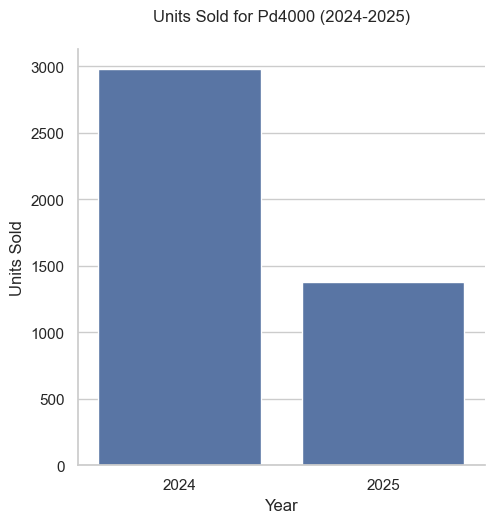

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

sns.catplot(data=hist_df, x="Year", y="Units Sold", kind="bar")
plt.title('Units Sold for Pd4000 (2024-2025)', pad=20)


We can also make a more detailed histogram showing distribution of units sold across the 52 weeks of the year for both 2024 and 2025 for comparison:

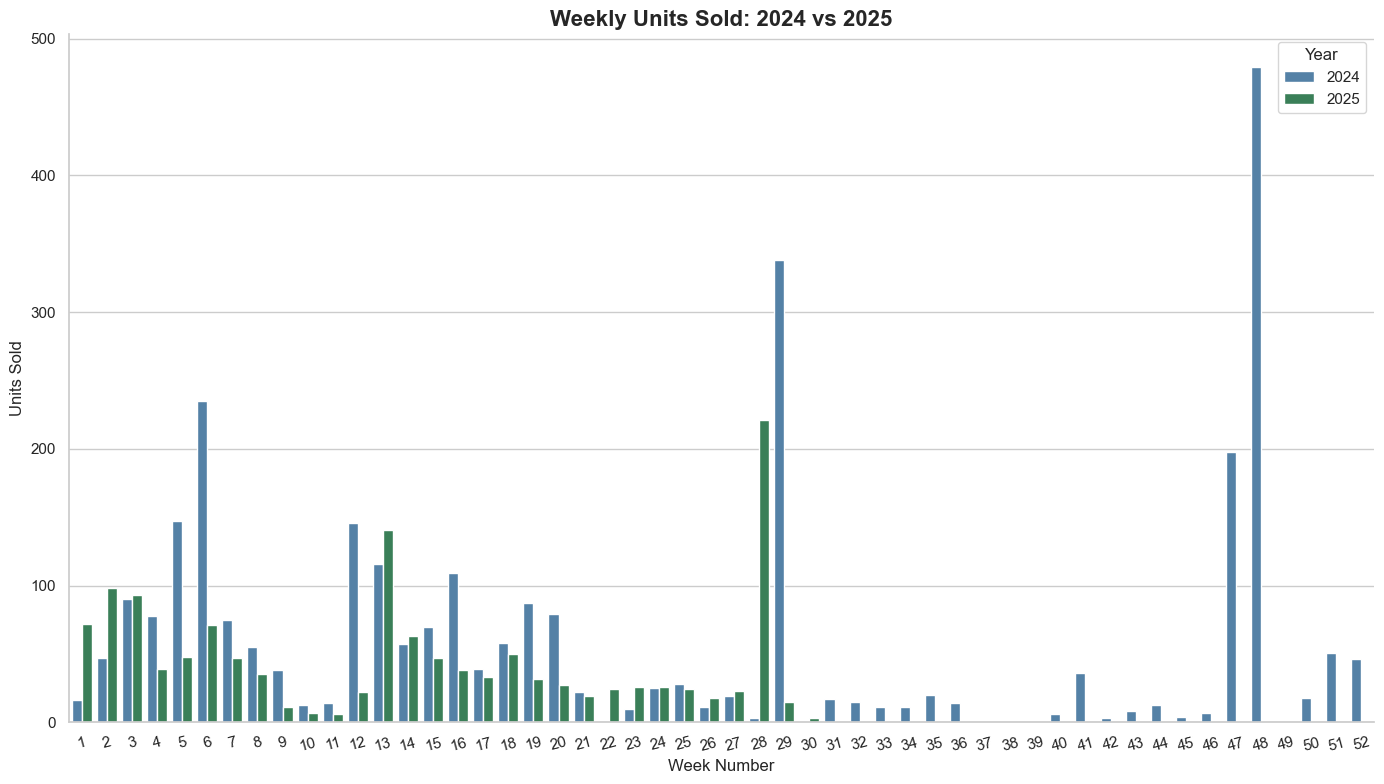

In [ ]:
df_filtered = analysis_df[(analysis_df['Product ID'] == 'Pd4000') & (analysis_df['Year'].isin([2024, 2025]))]

plt.figure(figsize=(14, 8))

sns.barplot(data=df_filtered, x='Week', y='Units Sold', hue='Year',
    palette={2024: 'steelblue', 2025: 'seagreen'}, 
)

plt.title('Weekly Units Sold: 2024 vs 2025', fontsize=16, fontweight='bold')
plt.xlabel('Week Number', fontsize=12)
plt.ylim(0, None)
plt.legend(title='Year', title_fontsize=12, fontsize=11)
plt.xticks(rotation=15)
plt.tight_layout()
sns.despine()



### Task 2
#### Year-on-Year Performance Comparison

Goal: Plot the total Sales trend with distinct lines for each year present in the dataset. Do the same in a different chart for OOS%.

##### Total Sales

First, we plot a total sales trend lines for each year. We would like to calculate the total sales as units_sold * avg_sales_price. I check the names of the columns below and rename for convenience.

In [119]:
print(analysis_df.columns.tolist())

analysis_df = analysis_df.rename(columns={' Avg Sales Price ': 'Avg Sales Price'})

['Product ID', 'Year-Week', 'Units Sold', 'Conversion %', ' Avg Sales Price ', 'OOS%', 'Year', 'Week']


Converting prices into a simple float format for calculations:

In [120]:
analysis_df['Avg Sales Price'] = analysis_df['Avg Sales Price'].str.replace('€', '').str.strip().astype(float)

In [121]:
analysis_df.head()

,Product ID,Year-Week,Units Sold,Conversion %,Avg Sales Price,OOS%,Year,Week
0,Pd3000,2024-01,157.0,0.027986,113.51,0.0,2024,1
1,Pd3000,2024-02,148.0,0.025708,113.49,0.0,2024,2
2,Pd3000,2024-03,98.0,0.015031,113.49,0.0,2024,3
3,Pd3000,2024-04,136.0,0.016185,105.23,0.0,2024,4
4,Pd3000,2024-05,143.0,0.019427,106.67,0.0,2024,5


Check if there are any instances where units were sold but the price is absent:

In [127]:
print(analysis_df[(analysis_df['Units Sold'].notna()) & (analysis_df['Units Sold'] != 0)  & (analysis_df['Avg Sales Price'].isna()) ])

Empty DataFrame
Columns: [Product ID, Year-Week, Units Sold, Conversion %, Avg Sales Price, OOS%, Year, Week, Total Sales]
Index: []


Now we are calculating total sales into its own column:

In [122]:
analysis_df['Total Sales'] = analysis_df['Units Sold'] * analysis_df['Avg Sales Price']

In [128]:
analysis_df.head()

,Product ID,Year-Week,Units Sold,Conversion %,Avg Sales Price,OOS%,Year,Week,Total Sales
0,Pd3000,2024-01,157.0,0.027986,113.51,0.0,2024,1,17821.07
1,Pd3000,2024-02,148.0,0.025708,113.49,0.0,2024,2,16796.52
2,Pd3000,2024-03,98.0,0.015031,113.49,0.0,2024,3,11122.02
3,Pd3000,2024-04,136.0,0.016185,105.23,0.0,2024,4,14311.28
4,Pd3000,2024-05,143.0,0.019427,106.67,0.0,2024,5,15253.81


Next, we are summing up the total sales across all products for each week within the year. The NaN values are ignored by sum(), but if all products have NaN in Total Sales, assumingly because none were sold in that period, we would like to keep the total sales result as NaN to differentiate between absent data and zero sum.

In [89]:
def smart_sum(x):
    """Sum that preserves NaN if all values are NaN"""
    if x.isna().all():
        return np.nan
    return x.sum()

We use this function now in aggregation. We also calculate ahead the average OOS% for each week.

In [90]:
agg_df = analysis_df.groupby(['Year', 'Week']).agg({
    'Total Sales': smart_sum,
    'OOS%': 'mean'
}).reset_index()

In [91]:
agg_df.head()

,Year,Week,Total Sales,OOS%
0,2024,1,25576.96,0.186560
1,2024,2,33273.76,0.176080
2,2024,3,30668.67,0.227520
3,2024,4,31497.58,0.021575
4,2024,5,40820.77,0.182120


Plotting the trend lines:

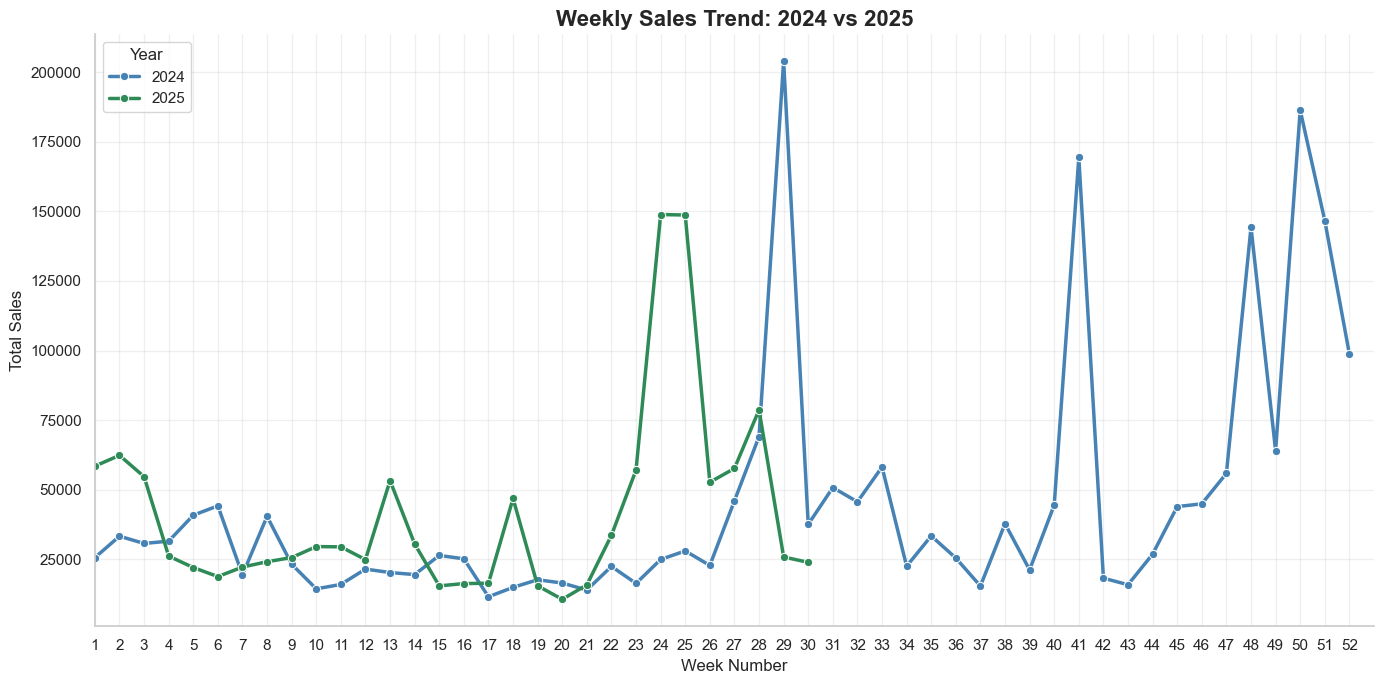

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

agg_df = agg_df[agg_df['Year'].isin([2024, 2025])] # drop 2026

plt.figure(figsize=(14, 7))

sns.lineplot(
    data=agg_df,
    x='Week',
    y='Total Sales',
    hue='Year',
    markers=True,          
    marker='o',
    palette={2024: 'steelblue', 2025: 'seagreen'}, 
    linewidth=2.5
)

plt.title('Weekly Sales Trend: 2024 vs 2025', fontsize=16, fontweight='bold')
plt.xlabel('Week Number', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.legend(title='Year', title_fontsize=12)
plt.xticks(range(1, 53))  # 52 weeks
plt.xlim(1, 53)
plt.grid(True, alpha=0.3)
plt.tight_layout()
sns.despine()

##### Total Units Sold trend line

We would also plot for comparison the trend line for total units sold (of each product).

In [134]:
sold_df = analysis_df.groupby(['Year', 'Week'])['Units Sold'].apply(smart_sum).reset_index()

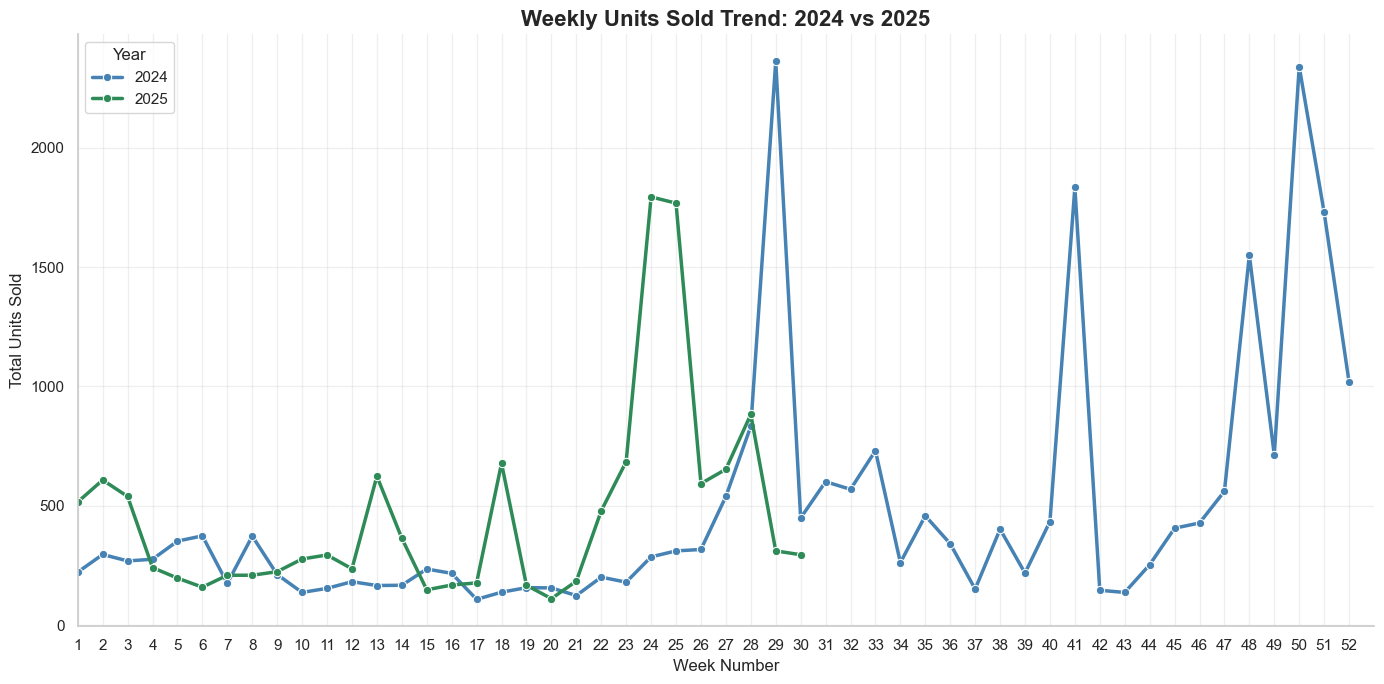

In [ ]:
sold_df = sold_df[sold_df['Year'].isin([2024, 2025])] # drop 2026

plt.figure(figsize=(14, 7))

sns.lineplot(
    data=sold_df,
    x='Week',
    y='Units Sold',
    hue='Year',
    markers=True,          
    marker='o',
    palette={2024: 'steelblue', 2025: 'seagreen'}, 
    linewidth=2.5
)

plt.title('Weekly Units Sold Trend: 2024 vs 2025', fontsize=16, fontweight='bold')
plt.xlabel('Week Number', fontsize=12)
plt.ylabel('Total Units Sold', fontsize=12)
plt.legend(title='Year', title_fontsize=12)
plt.xticks(range(1, 53))  # 52 weeks
plt.xlim(1, 53)
plt.grid(True, alpha=0.3)
plt.tight_layout()
sns.despine()

##### Average OOS% - trend line

To show the trend in Out of Stock %, we are using the previously calculated average OOS% to plot the trend lines.

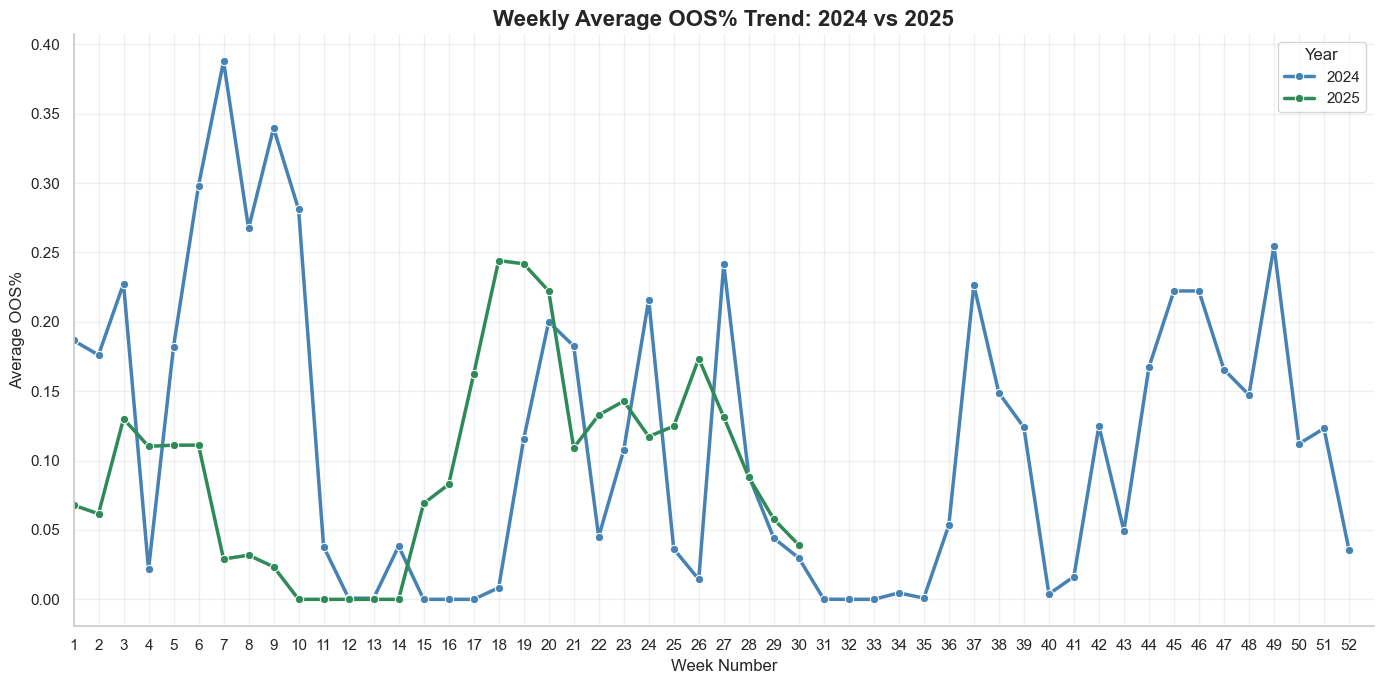

In [84]:
plt.figure(figsize=(14, 7))

sns.lineplot(
    data=agg_df,
    x='Week',
    y='OOS%',
    hue='Year',
    markers=True,          
    marker='o',
    palette={2024: 'steelblue', 2025: 'seagreen'}, 
    linewidth=2.5,
)

plt.title('Weekly Average OOS% Trend: 2024 vs 2025', fontsize=16, fontweight='bold')
plt.xlabel('Week Number', fontsize=12)
plt.ylabel('Average OOS%', fontsize=12)
plt.legend(title='Year', title_fontsize=12)
plt.xticks(range(1, 53))  # 52 weeks
plt.xlim(1, 53)
plt.grid(True, alpha=0.3)
plt.tight_layout()
sns.despine()

##### Total Weekly OOS% - trend line

In [ ]:
valid_df['OOS Traffic'] = valid_df['Traffic'] * valid_df['OOS%']

### Task 3
#### Product Sales Ranking

We will add a separate 'Rank' column to the dataframe that contains total sales for each product.

In [ ]:

product_sales = analysis_df.groupby(['Year', 'Product ID'])['Total Sales'].sum().reset_index()

product_sales['Rank'] = product_sales.groupby('Year')['Total Sales'] \
                                   .rank(ascending=False, method='min').astype(int)

product_sales.head()

,Year,Product ID,Total Sales,Rank
0,2024,Pd1000,775150.10,1
1,2024,Pd2000,482791.55,2
2,2024,Pd3000,324678.87,4
3,2024,Pd4000,371548.02,3
4,2024,Pd5000,317029.71,5


Then, we sort based on the rank and display the rank, the product id, and the total sales.

In [ ]:
ranked_2024 = product_sales[product_sales['Year'] == 2024] \
             .sort_values('Rank') \
             [['Rank', 'Product ID', 'Total Sales']]

ranked_2025 = product_sales[product_sales['Year'] == 2025] \
             .sort_values('Rank') \
             [['Rank', 'Product ID', 'Total Sales']]

def format_sales(df):
    df = df.copy()
    df['Total Sales'] = df['Total Sales'].apply(lambda x: f"€{x:,.2f}")
    return df

The results are displayed below.
The best products of 2024:

In [148]:
from IPython.display import display

display(format_sales(ranked_2024).style.hide(axis='index'))


Rank,Product ID,Total Sales
1,Pd1000,"€775,150.10"
2,Pd2000,"€482,791.55"
3,Pd4000,"€371,548.02"
4,Pd3000,"€324,678.87"
5,Pd5000,"€317,029.71"
6,Pd9000,"€30,281.12"
7,Pd6000,"€21,219.76"
8,Pd7000,"€20,442.47"
9,Pd8000,"€3,895.23"


The best products of 2025:

In [149]:
display(format_sales(ranked_2025).style.hide(axis='index'))

Rank,Product ID,Total Sales
1,Pd2000,"€443,635.03"
2,Pd1000,"€217,527.17"
3,Pd4000,"€180,660.74"
4,Pd5000,"€118,710.84"
5,Pd9000,"€115,536.05"
6,Pd3000,"€59,714.24"
7,Pd7000,"€40,430.35"
8,Pd8000,"€36,070.29"
9,Pd6000,"€33,220.15"


#### Adding conversion% and traffic

We need to calculate the traffic using Traffic = Units Sold / Conversion%. We will drop the entries where the conversion rate is not given or zero, in which case the traffic cannot be calculated.

In [94]:
valid_df = analysis_df.dropna(subset=['Conversion %']).copy()
valid_df = valid_df[valid_df['Conversion %'] > 0]

valid_df['Traffic'] = (valid_df['Units Sold'] / valid_df['Conversion %']).round().astype(int)
valid_df.head()


,Product ID,Year-Week,Units Sold,Conversion %,Avg Sales Price,OOS%,Year,Week,Total Sales,Traffic
0,Pd3000,2024-01,157.0,0.027986,113.51,0.0,2024,1,17821.07,5610
1,Pd3000,2024-02,148.0,0.025708,113.49,0.0,2024,2,16796.52,5757
2,Pd3000,2024-03,98.0,0.015031,113.49,0.0,2024,3,11122.02,6520
3,Pd3000,2024-04,136.0,0.016185,105.23,0.0,2024,4,14311.28,8403
4,Pd3000,2024-05,143.0,0.019427,106.67,0.0,2024,5,15253.81,7361


Calculating the total sales, average conversion rate, and total traffic for each week within each year:

In [298]:
product_rankings = valid_df.groupby(['Year', 'Product ID']).agg({
    'Total Sales': 'sum',
    'Conversion %': 'mean',
    'Traffic': 'sum',
}).reset_index()

product_rankings.head(10)

,Year,Product ID,Total Sales,Conversion %,Traffic
0,2024,Pd1000,775680.26,0.015471,323907
1,2024,Pd2000,483101.55,0.017326,222010
2,2024,Pd3000,324678.87,0.012713,209663
3,2024,Pd4000,371744.34,0.032131,99341
4,2024,Pd5000,317029.71,0.019312,127825
5,2024,Pd6000,21219.76,0.020170,20027
6,2024,Pd7000,20442.47,0.029396,12181
7,2024,Pd8000,3895.23,0.044114,1196
8,2024,Pd9000,30281.12,0.026739,19362
9,2025,Pd1000,217716.45,0.013649,180776


Similarly to the total sales, we add to the rankings conversion percentage and traffic.

In [300]:
product_rankings['Rank'] = product_rankings.groupby('Year')['Total Sales'] \
                                   .rank(ascending=False, method='min').astype(int)

ranked_2024 = product_rankings[product_rankings['Year'] == 2024] \
             .sort_values('Rank') \
             [['Rank', 'Product ID', 'Total Sales', 'Conversion %', 'Traffic']]

ranked_2025 = product_rankings[product_rankings['Year'] == 2025] \
             .sort_values('Rank') \
             [['Rank', 'Product ID', 'Total Sales', 'Conversion %', 'Traffic']]

def format_sales(df):
    df = df.copy()
    df['Total Sales'] = df['Total Sales'].apply(lambda x: f"€{x:,.2f}")
    return df

display(format_sales(ranked_2024).style.hide(axis='index'))
display(format_sales(ranked_2025).style.hide(axis='index'))


Rank,Product ID,Total Sales,Conversion %,Traffic
1,Pd1000,"€775,680.26",0.015471,323907
2,Pd2000,"€483,101.55",0.017326,222010
3,Pd4000,"€371,744.34",0.032131,99341
4,Pd3000,"€324,678.87",0.012713,209663
5,Pd5000,"€317,029.71",0.019312,127825
6,Pd9000,"€30,281.12",0.026739,19362
7,Pd6000,"€21,219.76",0.020170,20027
8,Pd7000,"€20,442.47",0.029396,12181
9,Pd8000,"€3,895.23",0.044114,1196


Rank,Product ID,Total Sales,Conversion %,Traffic
1,Pd2000,"€443,635.03",0.022131,160019
2,Pd1000,"€217,716.45",0.013649,180776
3,Pd4000,"€180,660.74",0.015983,81331
4,Pd5000,"€118,710.84",0.017836,43548
5,Pd9000,"€115,536.05",0.022775,60562
6,Pd3000,"€59,807.24",0.009949,41480
7,Pd7000,"€40,430.35",0.023442,17921
8,Pd8000,"€36,070.29",0.021476,23082
9,Pd6000,"€33,220.15",0.024002,15766


Next, we determine the products with highest conversion % and traffic for each year.

In [301]:
ranked_2024 = ranked_2024.reset_index()
ranked_2025 = ranked_2025.reset_index()

highest_conversion = ranked_2024.loc[ranked_2024['Conversion %'].astype(float).idxmax()]
print(f"Product with Highest Conversion Rate in 2024: {highest_conversion['Product ID']}")

highest_conversion = ranked_2025.loc[ranked_2025['Conversion %'].astype(float).idxmax()]
print(f"Product with Highest Conversion Rate in 2025: {highest_conversion['Product ID']}")


highest_traffic = ranked_2024.loc[ranked_2024['Traffic'].idxmax()]
print(f"Product with Highest Traffic in 2024: {highest_traffic['Product ID']}")

highest_traffic = ranked_2025.loc[ranked_2025['Traffic'].idxmax()]
print(f"Product with Highest Traffic in 2025: {highest_traffic['Product ID']}")

Product with Highest Conversion Rate in 2024: Pd8000
Product with Highest Conversion Rate in 2025: Pd6000
Product with Highest Traffic in 2024: Pd1000
Product with Highest Traffic in 2025: Pd1000


### Task 4
#### Event Calendar Analysis
We will determine which event generated the most traffic.
We start with analyzing the provided file that lists holiday events.

In [249]:
holidays = pd.read_csv('Event Calendar.txt', sep=',', header=0)
print(holidays)

      Year                 Event Name      Week Nr
0     2024             New Year's Day    WeekNum-1
1     2024               Black Friday   WeekNum-48
2     2024                   Epiphany    WeekNum-6
3     2024              Easter Sunday   WeekNum-13
4   2024 .               Black Friday   WeekNum-48
5     2024              Easter Monday   WeekNum-14
6     2024                 Labour Day  WeekNum-18-
7     2024              Christmas Day   WeekNum-52
8     2024                   Epiphany    WeekNum-6
9     2025             New Year's Day    WeekNum-1
10    2025                   Epiphany    WeekNum-1
11    2024               Black Friday   WeekNum-48
12    2025              Easter Sunday  WeekNum-16 
13    2025  Important Meeting Invites   WeekNum-10
14    2025              Easter Monday   WeekNum-17
15    2025                 Labour Day   WeekNum-18
16    2024               Cyber Monday  WeekNum-49 
17    2024               Singles' Day   WeekNum-45
18    2025               Black 

Renaming the columns and cleaning up:

In [250]:
holidays.columns = ['Year', 'Event Name', 'Week']

holidays['Year'] = holidays['Year'].str.replace(r'[^0-9]', '', regex=True).astype(int)
holidays['Week'] = holidays['Week'].str.replace(r'[^0-9]', '', regex=True).astype(int)
holidays['Event Name'] = holidays['Event Name'].str.strip()

print(holidays)

    Year                 Event Name  Week
0   2024             New Year's Day     1
1   2024               Black Friday    48
2   2024                   Epiphany     6
3   2024              Easter Sunday    13
4   2024               Black Friday    48
5   2024              Easter Monday    14
6   2024                 Labour Day    18
7   2024              Christmas Day    52
8   2024                   Epiphany     6
9   2025             New Year's Day     1
10  2025                   Epiphany     1
11  2024               Black Friday    48
12  2025              Easter Sunday    16
13  2025  Important Meeting Invites    10
14  2025              Easter Monday    17
15  2025                 Labour Day    18
16  2024               Cyber Monday    49
17  2024               Singles' Day    45
18  2025               Black Friday    48
19  2025               Cyber Monday    49
20  2025               Singles' Day    46
21  2025          Holiday in France     2
22  2025   Important Meeting Invit

Drop exact duplicates:

In [251]:
holidays = holidays.drop_duplicates()
print(holidays)

    Year                 Event Name  Week
0   2024             New Year's Day     1
1   2024               Black Friday    48
2   2024                   Epiphany     6
3   2024              Easter Sunday    13
5   2024              Easter Monday    14
6   2024                 Labour Day    18
7   2024              Christmas Day    52
9   2025             New Year's Day     1
10  2025                   Epiphany     1
12  2025              Easter Sunday    16
13  2025  Important Meeting Invites    10
14  2025              Easter Monday    17
15  2025                 Labour Day    18
16  2024               Cyber Monday    49
17  2024               Singles' Day    45
18  2025               Black Friday    48
19  2025               Cyber Monday    49
20  2025               Singles' Day    46
21  2025          Holiday in France     2
22  2025   Important Meeting Invite    10
23  2025                  Christmas    52
24  2024              Black Fridays    48
25  2025              Christmas Da

Check separately lists for 2024 and 2025. First is 2024:

In [252]:
print(holidays[holidays['Year'] == 2024].sort_values(by='Week'))

    Year      Event Name  Week
0   2024  New Year's Day     1
2   2024        Epiphany     6
3   2024   Easter Sunday    13
5   2024   Easter Monday    14
6   2024      Labour Day    18
17  2024    Singles' Day    45
24  2024   Black Fridays    48
1   2024    Black Friday    48
16  2024    Cyber Monday    49
7   2024   Christmas Day    52


Two Black Fridays during same year-week is suspicious, so we remove it.

In [253]:
holidays = holidays.drop(index=24) 
print(holidays[holidays['Year'] == 2024].sort_values(by='Week'))

    Year      Event Name  Week
0   2024  New Year's Day     1
2   2024        Epiphany     6
3   2024   Easter Sunday    13
5   2024   Easter Monday    14
6   2024      Labour Day    18
17  2024    Singles' Day    45
1   2024    Black Friday    48
16  2024    Cyber Monday    49
7   2024   Christmas Day    52


Now the list for 2025:

In [254]:
print(holidays[holidays['Year'] == 2025].sort_values(by='Week'))

    Year                 Event Name  Week
9   2025             New Year's Day     1
10  2025                   Epiphany     1
21  2025          Holiday in France     2
13  2025  Important Meeting Invites    10
22  2025   Important Meeting Invite    10
12  2025              Easter Sunday    16
14  2025              Easter Monday    17
15  2025                 Labour Day    18
20  2025               Singles' Day    46
18  2025               Black Friday    48
19  2025               Cyber Monday    49
23  2025                  Christmas    52
25  2025              Christmas Day    52


The two instances of suspicious holidays with the same year-week pairs are Important Meeting Invite(s) and Christmas (day). We assume they represent the same event, so we drop one of each. Also, it seems that Epiphany happens on different weeks in 2024 and 2025, which seems incorrect as it must be in January. Since it is usually celebrated on January 6, which is in week one in 2024, I will drop it. 

In [255]:
holidays = holidays.drop(index=[13, 23, 2, 10]) 
print(holidays)

    Year                Event Name  Week
0   2024            New Year's Day     1
1   2024              Black Friday    48
3   2024             Easter Sunday    13
5   2024             Easter Monday    14
6   2024                Labour Day    18
7   2024             Christmas Day    52
9   2025            New Year's Day     1
12  2025             Easter Sunday    16
14  2025             Easter Monday    17
15  2025                Labour Day    18
16  2024              Cyber Monday    49
17  2024              Singles' Day    45
18  2025              Black Friday    48
19  2025              Cyber Monday    49
20  2025              Singles' Day    46
21  2025         Holiday in France     2
22  2025  Important Meeting Invite    10
25  2025             Christmas Day    52


In [256]:
holidays = holidays.reset_index()

I will assume that events that are present only in 2025 were not relevent for 2024. We now will merge weekly_sales and holidays on Year and Week, the weeks without a holiday get NaN.

In [302]:
merged_data = pd.merge(
    valid_df,
    holidays,
    on=['Year', 'Week'],
    how='left'
)

print(merged_data)

    Product ID Year-Week  Units Sold  Conversion %  Avg Sales Price    OOS%  \
0       Pd3000   2024-01       157.0      0.027986           113.51  0.0000   
1       Pd3000   2024-02       148.0      0.025708           113.49  0.0000   
2       Pd3000   2024-03        98.0      0.015031           113.49  0.0000   
3       Pd3000   2024-04       136.0      0.016185           105.23  0.0000   
4       Pd3000   2024-05       143.0      0.019427           106.67  0.0000   
..         ...       ...         ...           ...              ...     ...   
496     Pd2000   2025-26       403.0      0.019859            87.43  0.3014   
497     Pd2000   2025-27       288.0      0.011799            94.00  0.5227   
498     Pd2000   2025-28       279.0      0.025052            88.86  0.1554   
499     Pd2000   2025-29        44.0      0.011937            82.67  0.3518   
500     Pd2000   2025-30        40.0      0.014035            82.69  0.3527   

     Year  Week  Total Sales  Traffic  index      E

In [303]:
merged_data = merged_data.drop(['index', 'Year-Week', 'OOS%', 'Conversion %', 'Avg Sales Price'], axis=1)
print(merged_data)

    Product ID  Units Sold  Year  Week  Total Sales  Traffic      Event Name
0       Pd3000       157.0  2024     1     17821.07     5610  New Year's Day
1       Pd3000       148.0  2024     2     16796.52     5757             NaN
2       Pd3000        98.0  2024     3     11122.02     6520             NaN
3       Pd3000       136.0  2024     4     14311.28     8403             NaN
4       Pd3000       143.0  2024     5     15253.81     7361             NaN
..         ...         ...   ...   ...          ...      ...             ...
496     Pd2000       403.0  2025    26     35234.29    20293             NaN
497     Pd2000       288.0  2025    27     27072.00    24408             NaN
498     Pd2000       279.0  2025    28     24791.94    11137             NaN
499     Pd2000        44.0  2025    29      3637.48     3686             NaN
500     Pd2000        40.0  2025    30      3307.60     2850             NaN

[501 rows x 7 columns]


Determining the events that generated the largest traffic in 2025:

In [304]:
event_traffic_2025 = merged_data[merged_data['Year'] == 2025].groupby('Event Name')['Traffic'] \
    .sum() \
    .sort_values(ascending=False)

print(event_traffic_2025)

Event Name
New Year's Day              30488
Holiday in France           26562
Labour Day                  17809
Important Meeting Invite    12496
Easter Sunday                8749
Easter Monday                8504
Name: Traffic, dtype: int64


In 2025, the most traffic was generated during New Year's week. For 2024, we check similarly:

In [305]:
event_traffic_2024 = merged_data[merged_data['Year'] == 2024].groupby('Event Name')['Traffic'] \
    .sum() \
    .sort_values(ascending=False)

print(event_traffic_2024)

Event Name
Black Friday      49419
Christmas Day     38121
Singles' Day      25205
Cyber Monday      22401
New Year's Day     9385
Easter Monday      8968
Easter Sunday      8417
Labour Day         7349
Name: Traffic, dtype: int64


The event that generated the most traffic in 2024 is Black Friday. All events in top 4 of 2024 did not happen yet in 2025, and the New Year's traffic of 2024 is much lower than that in 2025.

### Task 5
#### Out of Stock Analysis

First, we will calculate the Out Of Stock % for 2024 and 2025. We will calculate it as **Total OOS Trafic / Total Traffic** for each year, where **Total OOS Traffic** represents the number of times users reached out for the products on the website while the latter was out of stock (throughout the whole year). 

The OOS Traffic for each week:

In [95]:
valid_df['OOS Traffic'] = valid_df['Traffic'] * valid_df['OOS%']

In [97]:
valid_df.head(8)

,Product ID,Year-Week,Units Sold,Conversion %,Avg Sales Price,OOS%,Year,Week,Total Sales,Traffic,OOS Traffic
0,Pd3000,2024-01,157.0,0.027986,113.51,0.0000,2024,1,17821.07,5610,0.0000
1,Pd3000,2024-02,148.0,0.025708,113.49,0.0000,2024,2,16796.52,5757,0.0000
2,Pd3000,2024-03,98.0,0.015031,113.49,0.0000,2024,3,11122.02,6520,0.0000
3,Pd3000,2024-04,136.0,0.016185,105.23,0.0000,2024,4,14311.28,8403,0.0000
4,Pd3000,2024-05,143.0,0.019427,106.67,0.0000,2024,5,15253.81,7361,0.0000
5,Pd3000,2024-06,100.0,0.013403,113.66,0.0000,2024,6,11366.00,7461,0.0000
6,Pd3000,2024-07,49.0,0.009587,107.32,0.1648,2024,7,5258.68,5111,842.2928
7,Pd3000,2024-08,313.0,0.016425,101.13,0.0693,2024,8,31653.69,19056,1320.5808


The following function takes in year and returns the calculated yearly Out of Stock percentage. 

In [320]:
def calculate_yearly_oos(year):
    year_data = valid_df[valid_df['Year'] == year]
    total_traffic = year_data['Traffic'].sum()
    oos_traffic = year_data['OOS Traffic'].sum()
    return (oos_traffic / total_traffic) * 100

In [322]:
print(f"The Out of Stock percentage in 2024: {calculate_yearly_oos(2024):.2f}%")
print(f"The Out of Stock percentage in 2025: {calculate_yearly_oos(2025):.2f}%")

The Out of Stock percentage in 2024: 9.78%
The Out of Stock percentage in 2025: 11.59%


##### The products with highest Out of Stock % in 2025

Merging with the holidays dataframe as previously:

In [324]:
merged_data_with_oos = pd.merge(
    valid_df,
    holidays,
    on=['Year', 'Week'],
    how='left'
)

merged_data_with_oos.head()

,Product ID,Year-Week,Units Sold,Conversion %,Avg Sales Price,OOS%,Year,Week,Total Sales,Traffic,OOS Traffic,index,Event Name
0,Pd3000,2024-01,157.0,0.027986,113.51,0.0,2024,1,17821.07,5610,0.0,0.0,New Year's Day
1,Pd3000,2024-02,148.0,0.025708,113.49,0.0,2024,2,16796.52,5757,0.0,NaN,NaN
2,Pd3000,2024-03,98.0,0.015031,113.49,0.0,2024,3,11122.02,6520,0.0,NaN,NaN
3,Pd3000,2024-04,136.0,0.016185,105.23,0.0,2024,4,14311.28,8403,0.0,NaN,NaN
4,Pd3000,2024-05,143.0,0.019427,106.67,0.0,2024,5,15253.81,7361,0.0,NaN,NaN


Filter for 2025 only:

In [325]:
oos_by_events_2025 = merged_data_with_oos[merged_data_with_oos['Year'] == 2025]

In [328]:
oos_by_events_2025 = oos_by_events_2025.drop('index', axis = 1)
oos_by_events_2025.head()

,Product ID,Year-Week,Units Sold,Conversion %,Avg Sales Price,OOS%,Year,Week,Total Sales,Traffic,OOS Traffic,Event Name
52,Pd3000,2025-01,7.0,0.003476,143.49,0.0,2025,1,1004.43,2014,0.0,New Year's Day
53,Pd3000,2025-02,9.0,0.011643,118.70,0.0,2025,2,1068.30,773,0.0,Holiday in France
54,Pd3000,2025-03,5.0,0.003605,98.77,0.0,2025,3,493.85,1387,0.0,NaN
55,Pd3000,2025-04,31.0,0.017289,102.19,0.0,2025,4,3167.89,1793,0.0,NaN
56,Pd3000,2025-05,26.0,0.014428,101.77,0.0,2025,5,2646.02,1802,0.0,NaN


To determine which events experienced the highest OOS%, I will create a ranking. I calculate OOS% for each event similarly to the total calculations in the prvious subtask, but before summing up the (OOS) traffics of different products we will group by events of 2025.

In [ ]:
# total_traffic_by_event = event_traffic = oos_by_events_2025.groupby('Event Name')['Traffic'].sum()
total_traffic_by_event = oos_by_events_2025.groupby('Event Name')['Traffic'].sum()
oos_traffic_by_event = oos_by_events_2025.groupby('Event Name')['OOS Traffic'].sum()

We merge the results into one dataframe:

In [344]:
merge_traffics = pd.merge(
    total_traffic_by_event,
    oos_traffic_by_event,
    on=['Event Name']
)

display(merge_traffics)

,Traffic,OOS Traffic
Event Name,,
Easter Monday,8504,707.2766
Easter Sunday,8749,0.0000
Holiday in France,26562,5787.1992
Important Meeting Invite,12496,0.0000
Labour Day,17809,0.0000
New Year's Day,30488,10790.2600


Now the final OOS% for each event:

In [345]:
merge_traffics["Event OOS%"] =  (merge_traffics['OOS Traffic'] / merge_traffics["Traffic"]) * 100
event_oos_ranking = merge_traffics.sort_values('Event OOS%', ascending = False)

In [348]:
event_oos_ranking_formatted = event_oos_ranking.copy()
event_oos_ranking_formatted['Event OOS%'] = event_oos_ranking_formatted['Event OOS%'].map(lambda x: f"{x:.2f}%")

display(event_oos_ranking_formatted)

,Traffic,OOS Traffic,Event OOS%
Event Name,,,
New Year's Day,30488,10790.2600,35.39%
Holiday in France,26562,5787.1992,21.79%
Easter Monday,8504,707.2766,8.32%
Easter Sunday,8749,0.0000,0.00%
Important Meeting Invite,12496,0.0000,0.00%
Labour Day,17809,0.0000,0.00%


Therefore, we see that New Year, Holiday in France, and Easter (Monday) had the highest Out of Stock %.

##### Total Weekly OOS% - trend line (task 2 revisit)

In part 2, we plotted a trend line for OOS% by taking the average OOS% of each week. Now similarly to the analysis of this part we will plot a trend line for total weekly OOS%.

In [112]:
valid_df.tail(20)

,Product ID,Year-Week,Units Sold,Conversion %,Avg Sales Price,OOS%,Year,Week,Total Sales,Traffic,OOS Traffic
753,Pd2000,2025-11,11.0,0.013784,89.64,0.0000,2025,11,986.04,798,0.0000
754,Pd2000,2025-12,12.0,0.016129,88.37,0.0000,2025,12,1060.44,744,0.0000
755,Pd2000,2025-13,131.0,0.036943,63.73,0.0000,2025,13,8348.63,3546,0.0000
756,Pd2000,2025-14,97.0,0.034324,68.35,0.0000,2025,14,6629.95,2826,0.0000
757,Pd2000,2025-15,28.0,0.029106,84.90,0.0000,2025,15,2377.20,962,0.0000
758,Pd2000,2025-16,17.0,0.020910,80.61,0.0000,2025,16,1370.37,813,0.0000
759,Pd2000,2025-17,24.0,0.021314,75.77,0.0000,2025,17,1818.48,1126,0.0000
760,Pd2000,2025-18,434.0,0.062187,57.98,0.0000,2025,18,25163.32,6979,0.0000
761,Pd2000,2025-19,76.0,0.028107,81.96,0.0000,2025,19,6228.96,2704,0.0000
762,Pd2000,2025-20,34.0,0.024303,82.44,0.0000,2025,20,2802.96,1399,0.0000


In [ ]:
weekly_traffic = valid_df.groupby(['Year', 'Week'])['Traffic'].sum()
weekly_oos_traffic = valid_df.groupby(['Year', 'Week'])['OOS Traffic'].sum()

merge_weekly_traffics = pd.merge(
    weekly_traffic,
    weekly_oos_traffic,
    on=['Year', 'Week']
).reset_index()

merge_weekly_traffics["Weekly OOS%"] =  (merge_weekly_traffics['OOS Traffic'] / merge_weekly_traffics["Traffic"]) * 100


,Year,Week,Traffic,OOS Traffic,Weekly OOS%
0,2024,1,9385,53.1696,0.566538
1,2024,2,11973,84.5184,0.705908
2,2024,3,12746,560.4946,4.397416
3,2024,4,13642,169.0617,1.239274
4,2024,5,13459,68.2950,0.507430
...,...,...,...,...,...
77,2025,26,41893,7274.3734,17.364174
78,2025,27,60028,14565.6912,24.264828
79,2025,28,39615,7978.6443,20.140463
80,2025,29,15893,1703.8525,10.720773


In [111]:
merge_weekly_traffics.tail(20)

,Year,Week,Traffic,OOS Traffic,Weekly OOS%
62,2025,11,17320,0.0000,0.000000
63,2025,12,13490,0.0000,0.000000
64,2025,13,25285,0.0000,0.000000
65,2025,14,13887,0.0000,0.000000
66,2025,15,10657,0.0000,0.000000
67,2025,16,8749,0.0000,0.000000
68,2025,17,8504,707.2766,8.316987
69,2025,18,17809,0.0000,0.000000
70,2025,19,8660,0.0000,0.000000
71,2025,20,6316,0.0000,0.000000


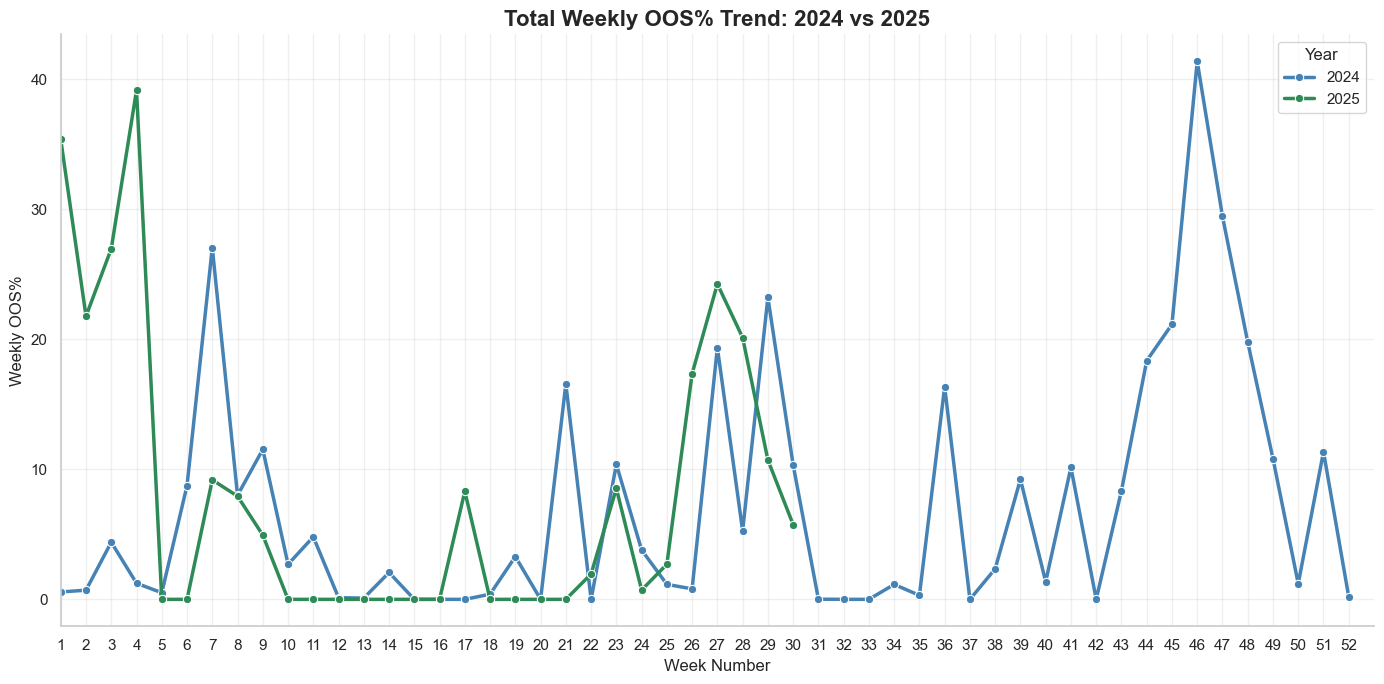

In [108]:
plt.figure(figsize=(14, 7))

sns.lineplot(
    data=merge_weekly_traffics,
    x='Week',
    y='Weekly OOS%',
    hue='Year',
    markers=True,          
    marker='o',
    palette={2024: 'steelblue', 2025: 'seagreen'}, 
    linewidth=2.5,
)

plt.title('Total Weekly OOS% Trend: 2024 vs 2025', fontsize=16, fontweight='bold')
plt.xlabel('Week Number', fontsize=12)
plt.ylabel('Weekly OOS%', fontsize=12)
plt.legend(title='Year', title_fontsize=12)
plt.xticks(range(1, 53))  # 52 weeks
plt.xlim(1, 53)
plt.grid(True, alpha=0.3)
plt.tight_layout()
sns.despine()

There is a difference in the two provided trend line plots for OOS% ( Average OOS% vs Weekly OOS%). Since the Traffic is calculated from the Conversion % and the Units Sold, there might be instances where there is no data for units sold and/or conversion%  (or they are zero) while the OOS% is not to zero. Then the calculated OOS Traffic will be zero, which can result in Weekly OOS% = 0 while the Average OOS% is not zero if at least one product had a non-zero OOS%.

### Task 6
#### Sales Threshold Analysis

To do the analysis, we create Year, Month, and Quarter columns. For that we will create a full date (yy-mm-dd) column using pd.to_datetime where for the weekday we will indicate the Monday of the given week. 

In [365]:
sales_df = df.copy()

sales_df['Date'] = pd.to_datetime(sales_df['Year-Week'] + '-1', format='%Y-%W-%w') # 1 for Monday

sales_df['Year'] = sales_df['Date'].dt.year
sales_df['Month'] = sales_df['Date'].dt.month
sales_df['Quarter'] = sales_df['Date'].dt.quarter

In [366]:
sales_df.head(10)

,Product ID,Year-Week,Units Sold,Conversion %,Avg Sales Price,OOS%,Date,Year,Month,Quarter
0,Pd3000,2024-01,157.0,0.027986,€ 113.51,0.0000,2024-01-01,2024,1,1
1,Pd3000,2024-02,148.0,0.025708,€ 113.49,0.0000,2024-01-08,2024,1,1
2,Pd3000,2024-03,98.0,0.015031,€ 113.49,0.0000,2024-01-15,2024,1,1
3,Pd3000,2024-04,136.0,0.016185,€ 105.23,0.0000,2024-01-22,2024,1,1
4,Pd3000,2024-05,143.0,0.019427,€ 106.67,0.0000,2024-01-29,2024,1,1
5,Pd3000,2024-06,100.0,0.013403,€ 113.66,0.0000,2024-02-05,2024,2,1
6,Pd3000,2024-07,49.0,0.009587,€ 107.32,0.1648,2024-02-12,2024,2,1
7,Pd3000,2024-08,313.0,0.016425,€ 101.13,0.0693,2024-02-19,2024,2,1
8,Pd3000,2024-09,156.0,0.012060,€ 101.56,0.0070,2024-02-26,2024,2,1
9,Pd3000,2024-10,109.0,0.015505,€ 101.16,0.0007,2024-03-04,2024,3,1


Count the monthly sales:

In [377]:
monthly_sales = (sales_df.groupby(['Product ID', 'Year', 'Month', 'Quarter'])['Units Sold']
                 .sum()
                 .reset_index())

In [382]:
monthly_sales.head(20)

,Product ID,Year,Month,Quarter,Units Sold
0,Pd1000,2024,1,1,334.0
1,Pd1000,2024,2,1,81.0
2,Pd1000,2024,3,1,69.0
3,Pd1000,2024,4,2,58.0
4,Pd1000,2024,5,2,20.0
5,Pd1000,2024,6,2,21.0
6,Pd1000,2024,7,3,98.0
7,Pd1000,2024,8,3,26.0
8,Pd1000,2024,9,3,827.0
9,Pd1000,2024,10,4,1736.0


Filtering for instances where any product's monthly sales exceed 1000:

In [385]:
high_sales = monthly_sales[monthly_sales['Units Sold'] > 1000]

In [391]:
display(high_sales)

,Product ID,Year,Month,Quarter,Units Sold
9,Pd1000,2024,10,4,1736.0
10,Pd1000,2024,11,4,1322.0
11,Pd1000,2024,12,4,4458.0
12,Pd1000,2025,1,1,1032.0
31,Pd2000,2024,7,3,3383.0
32,Pd2000,2024,8,3,1449.0
42,Pd2000,2025,6,2,3803.0


Counting the number of such instances for each Year-Quarter combination:

In [387]:
high_sales_quarter_count = high_sales.groupby(['Year', 'Quarter']).size() \
    .reset_index(name='High Sales Instances')

In [388]:
display(high_sales_quarter_count)

,Year,Quarter,High Sales Instances
0,2024,3,2
1,2024,4,3
2,2025,1,1
3,2025,2,1


Next, to rank the products based on the number of times they meet the threshold of exceeding 1000 monthly sales within Year-Quarter we are going to count such instances per product:

In [404]:
product_high_sales = monthly_sales.groupby('Product ID') \
                        .apply(lambda x: (x['Units Sold'] > 1000).sum(), include_groups=False) \
                        .reset_index(name='Threshold Met Count')

product_high_sales['Rank'] = product_high_sales['Threshold Met Count'].rank(method='dense', ascending=False).astype(int)

In [405]:
display(product_high_sales)

,Product ID,Threshold Met Count,Rank
0,Pd1000,4,1
1,Pd2000,3,2
2,Pd3000,0,3
3,Pd4000,0,3
4,Pd5000,0,3
5,Pd6000,0,3
6,Pd7000,0,3
7,Pd8000,0,3
8,Pd9000,0,3


### Web Scrapping

We will be using Beautiful Soup package for parsing html. We load the links first. The results will be written into a dictionary called data.

In [291]:
urls = [
    "https://www.bol.com/nl/nl/p/p/9300000173172033/?cstrackid=097b4833-0acb-43be-b23b-c5776a2ef480&Referrer=ADVNLPPcef5f300cdbf929700e4c9fb21681172446&utm_source=1172446&utm_medium=Affiliates&utm_campaign=CPS&utm_content=txl",
    "https://www.bol.com/nl/nl/p/philips-3000-serie-airfryer-7-2l-na341-00/9300000186182184/?cid=1754055247154-4070853182216&bltgh=n6wwiHRTkWC9QmNaonNLzg.4_82.90.ProductTitle",
    "https://www.bol.com/nl/nl/p/philips-5000-series-dual-basket-airfryer-na551-00-stoomfunctie-dubbele-mand-9l-tot-6-personen/9300000193078812/?cid=1754055520246-7150901137838&bltgh=rx0wotlCI3OAjHHzDVJH8A.4_69.74.ProductTitle",
    "https://www.bol.com/nl/nl/p/philips-1000-series-na130-00-airfryer-1000-serie-6-2-liter/9300000177050952/?cid=1754055247154-4506780939805&bltgh=n6wwiHRTkWC9QmNaonNLzg.4_82.89.ProductTitle",
    "https://www.bol.com/nl/nl/p/philips-oneup-elektrische-dweil-5000-series-xv5113-01-dweilsysteem-vloerreiniger/9300000199000097/?bltgh=oZLV3olgDa9seWklppJNGQ.4_20.23.ProductTitle",
    "https://www.bol.com/nl/nl/p/philips-powerpro-compact-fc9331-09-stofzuiger-zonder-zak/9200000084475208/?bltgh=rc213GrXhgKMNDCpeEdB-A.6_27.30.ProductTitle",
    "https://www.bol.com/nl/nl/p/philips-3000-series-compacte-en-opvouwbare-handstomer/9300000114223182/?bltgh=jK0yOUEflRmSYHqgkKREgw.4_20.23.ProductTitle",
    "https://www.bol.com/nl/nl/p/philips-l-or-barista-sublime-lm9012-20-koffiecupmachine-grijs/9300000071082408/?bltgh=oEbM6VuOT7Gl2jSCHexPkw.4_20.42.ProductTitle",
    "https://www.bol.com/nl/nl/p/philips-2200-serie-ep2220-10-espressomachine-zwart/9200000106983899/?bltgh=t-t1vO-SkQ1LWBBF-VVOhQ.4_20.26.ProductTitle",
    "https://www.bol.com/nl/nl/p/philips-5400-series-ep5447-90-volautomatische-espressomachines/9300000006026349/?bltgh=t-t1vO-SkQ1LWBBF-VVOhQ.4_20.41.ProductTitle",
    "https://www.bol.com/nl/nl/p/philips-baristina-bar300-60-espressomachine-koffiemachine-met-bonen-zwart/9300000186181869/?bltgh=oimAbJanoS6YBuoTu3ZPBA.4_19.22.ProductTitle",
    "https://www.bol.com/nl/nl/p/philips-aquatrio-9000-serie-xw9383-01-steelstofzuiger-dweil/9300000126637130/?bltgh=gwfwKaqvMU8-x68--q5Hlg.4_15.20.ProductTitle"
]

Next, I opened one of the links and identified the elements we need to scrape: the name of a product, the section with all specifications, the different sections inside under different subtitles, 

In [293]:
data = []

for url in urls:
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    product = soup.find("h1").get_text(strip = True) # product name

    specs_slot = soup.find("section", class_ = "js_slot-specifications") # section with all product specifications
    spec_sections = specs_slot.find_all("div", class_ = "specs") # sections per each subtitle 


    for section in spec_sections:
        subtitle_tag = section.find("h3") # subtitle of specifications
        subtitle = subtitle_tag.get_text(strip = True) 

        rows = section.find_all("div", class_="specs__row")

        for row in rows:

            label = row.find("dt").get_text(strip=True) # specification title
            value = row.find("dd").get_text(strip=True) # specification's value

            data.append({
                "Product Name": product,
                "Subtitle": subtitle,
                "Specification": label,
                "Value": value
            })    

data_df = pd.DataFrame(data)

Exporting the dataframe with results into an excel file:

In [294]:
data_df.to_excel("bol_specs.xlsx", index=False)